Tesseract Overview
-----------------------

This notebook is supposed to provide a brief overview over the Tesseract framework (and might be later adapted to Transcend as well).


    ├── tesseract             <- Main folder
    │   ├── mock.py           <- Module for generating test distributions for use with Tesseract
    │   ├── evaluation.py     <- This is the class where the magic happens  ;)
    │   ├── metrics.py        <- Various methods to calculate and output metrics (including AUT)
    │   └── ...

## Running this Notebook 

1. Run `make data` to pull the necessary data files. 
2. Reproduce Drebin graph from paper (Figure 5)

---

In [9]:
import os
import json
import numpy as np
from datetime import datetime
from sklearn.feature_extraction import DictVectorizer

import matplotlib.pyplot as plt

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_PATH = os.path.join(PROJ_ROOT, 'data', 'processed')

features_file, labels_file, meta_file = os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-X.json'), os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-Y.json'), os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-meta.json')

with open(features_file) as json_file:
    D = json.load(json_file)
    for datapoint in D:
        del datapoint['sha256']
    vec = DictVectorizer()  
    X = vec.fit_transform(D) # transform key-value (JSON) into sparse feature vector
    
with open(labels_file) as json_file:
    labels = json.load(json_file)
    y = np.array([l[0] for l in labels])
    
with open(meta_file) as json_file:
    meta = json.load(json_file)
    t = list()
    for m in meta:
        timestamp = datetime.strptime(m['dex_date'], '%Y-%m-%dT%H:%M:%S')
        t.append(timestamp)
    t = np.array(t)

In [2]:
# View the feature names for context
print(vec.get_feature_names_out())

['activities::#Pray714' 'activities::$Viewer' 'activities::%' ...
 'urls::https://zurvita_sd_success_com/account/login'
 'urls::https://zuul_your_md'
 'urls::https://zxing_googlecode_com/files/BarcodeScanner3_1_apk']


In [4]:
# What does the time array look like? 
print(t[:1])

[datetime.datetime(2016, 4, 5, 17, 58, 46)]


### Visualise the temporal distribution of the dataset

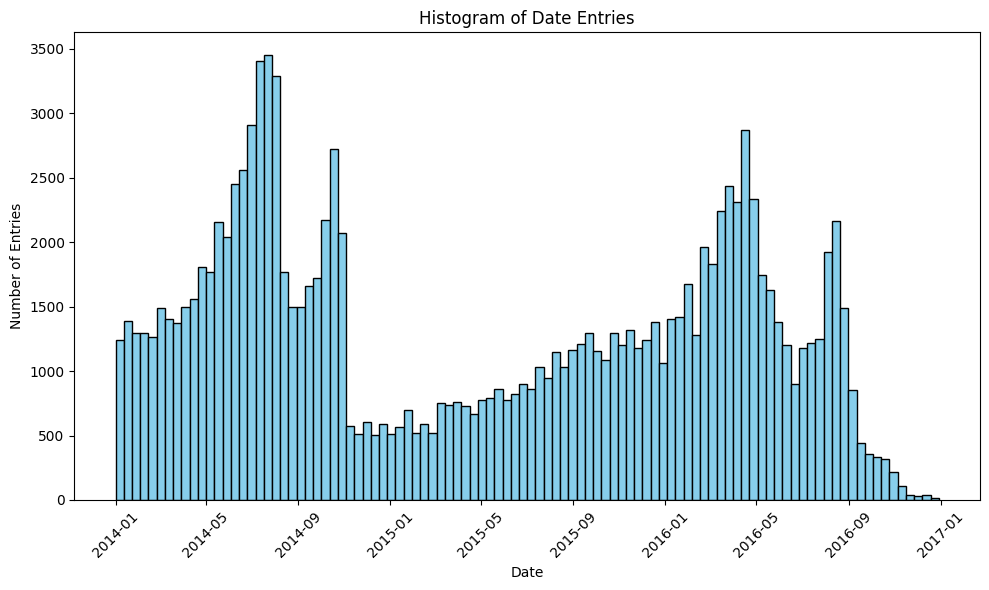

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(t, bins=100, edgecolor='black', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.title('Histogram of Date Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
print(f"The earliest timestamp in the dataset is {t.min()}")
print(f"The latest timestamp in the dataset is {t.max()}")

The earliest timestamp in the dataset is 2014-01-01 00:25:40
The latest timestamp in the dataset is 2016-12-29 15:17:46


### Partition the dataset 

Using the `time_aware_train_test_split()` function from Tesseract, we split the
dataset into train and test data + an array containing the timestamps. The
function makes sure that all the training data is temporally before the testing
data.

`train_size` specifies how many months (calculated starting at the earliest
timestamp in the dataset) we want to use for training data. The `test_size`
parameter splits the remaining data into periods of `test_size`. 

In this case, we're using months, but you can also set the granularity to `days`
or `years`.

Since our dataset spans over the time period of three years, 2014 to 2016, we
will train on the first 12 months and test the model on 24 1-month periods of
the apps published in 2015 and 2016.

In [5]:
from tesseract import evaluation, temporal, metrics, mock

# Partition dataset
splits = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

In [6]:
from sklearn.svm import LinearSVC

# Perform a timeline evaluation
clf = LinearSVC()
results = evaluation.fit_predict_update(clf, *splits)
    
# View results 
metrics.print_metrics(results)
    
# View AUT(F1, 24 months) as a measure of robustness over time 
print(metrics.aut(results, 'f1'))

0it [00:00, ?it/s]/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
24it [00:13,  1.83it/s]

------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24   
------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |    144    129    215    183    221    216    275    272    354    313    374    369    344    476    635    612    452    278    352    564    148     81     23      8
Actual neg  |   1564   1231   1888   1838   1953   2098   2521   2768   3077   2932   3010   3289   3478   3959   5818   6368   4052   2806   3027   4881   1377    758    190     67
Total       |   1708   1360   2103   2021   2174   2314   2796   3040   3431   3245   33

### Plotting the results

F1 AUT: 0.5765278129669974
Recall AUT: 0.47808007224822924
Precision AUT: 0.7552155668665173


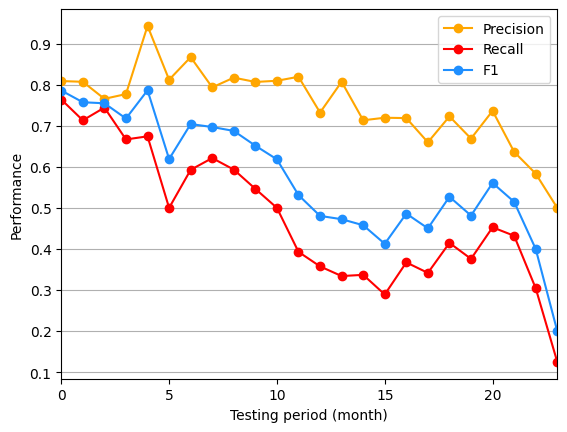

In [13]:
print(f"F1 AUT: {metrics.aut(results, 'f1')}")
print(f"Recall AUT: {metrics.aut(results, 'recall')}")
print(f"Precision AUT: {metrics.aut(results, 'precision')}")
#%%
from pylab import *

pendleblue='#1f8fff'
pendleyellow='#ffa600'

'#FF9999', '#FFDD99', '#AAEEEE'
plot(results['precision'], marker='o', color=pendleyellow)
plot(results['recall'], marker='o', color='red')
plot(results['f1'], marker='o', color=pendleblue)
legend(['Precision', 'Recall', 'F1'])
xlim([0,23])
xlabel('Testing period (month)')
ylabel('Performance')
grid(axis = 'y')

In the results we can see that the first few months of 2015 still yield a pretty
good performance: The malware produced in the beginnin of 2015 is likely very
similar to the training data. The further we are in the future, the worse recall
and precision get, decreasing the F1-Score. 